In [1]:
!pip install yfinance

     |████████████████████████████████| 6.3MB 6.5MB/s 
  Created wheel for yfinance: filename=yfinance-0.1.59-py2.py3-none-any.whl size=23455 sha256=3372038f24ad600f748b992629e884b9dd032f638342a5a60c72dba1d20084bf
  Stored in directory: /root/.cache/pip/wheels/f8/2a/0f/4b5a86e1d52e451757eb6bc17fd899629f0925c777741b6d04
Successfully built yfinance
  Found existing installation: lxml 4.2.6
    Uninstalling lxml-4.2.6:
      Successfully uninstalled lxml-4.2.6


In [2]:
!pip install pyod

     |████████████████████████████████| 112kB 5.4MB/s 
  Created wheel for pyod: filename=pyod-0.8.9-cp37-none-any.whl size=121413 sha256=43fc9d59292c62a36626ab33ebd0c3c188830eecefa56ec413e026d8e11a01ed
  Stored in directory: /root/.cache/pip/wheels/9b/31/18/f12932b880f1ce4c181cbe51454ddaaa02665ad7cfc663f639
Successfully built pyod


In [3]:
import yfinance as yf
import datetime 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import IsolationForest
from sklearn.cluster import DBSCAN
import scipy.stats as stats
#from outliers import smirnov_grubbs as grubbs
from pyod.models.hbos import HBOS
from sklearn.svm import OneClassSVM
from scipy.stats import shapiro
from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import LocalOutlierFactor

We have taken 'India Bulls Housing Finance' as our company of interest from period 1st January,2020 to 20th May,2021. 

In [4]:
df = yf.download("ADANIENT.NS", start="2020-01-01", end="2021-05-20",group_by="ticker") 

[*********************100%***********************]  1 of 1 completed


In [5]:
df.to_csv('Adani_enterprise.csv')

Main code start from this cell

In [6]:
df=pd.read_csv('Adani_enterprise.csv')

We started with features -
  1. Close - Closing Price of share.
  2. Volume - Number of shares traded in a day.
  3. Fluctuations - Difference of daily high and daily low
  4. Lag 1 - Momentum of 1 day ( Today's closing price - yesterday's closing price)
  5. Lag 2 - Momentum of 2 days
  6. Lag 3 - Momentum of 3 days
  7. Lag 4 - Momentum of 4 days
  8. Lag 5 - Momentum of 5 days  #Maximum momentum for a week to be considered for anomaly 
  9. Log daily Returns - It is log(today's closing price) - log(yesterday's closing price). Mean of the variable gives     central tendency. Positive value indicates stock is growing on average. It's standard deviation gives the volatility  (Higher the value of standard deviation more the risk).
  
Methods used (explained further in notebook)- 
1. Bollinger Bands
2. CCI 
3. Isolation Forest
4. DBSCAN
5. HBOS
6. Local Outlier Factor

so df11 means outlier from close as feature and algorithm as bollinger bands

df1233 means outlier from close, volume and fluctuations with isolation forest as algorithm 

do1 = Final output anomaly from bollinger bands and CCI index
do2 = Final output anomaly from HBOS

In [7]:
df['Fluctuations'] = df['High'] - df['Low']
df['Daily Log Returns']=np.log(df['Close'])-np.log(df['Close'].shift(1))
df['Lag1']=(df['Close']-df['Close'].shift(1))
df['Lag2']=(df['Close']-df['Close'].shift(2))
df['Lag3']=(df['Close']-df['Close'].shift(3))
df['Lag4']=(df['Close']-df['Close'].shift(4))
df['Lag5']=(df['Close']-df['Close'].shift(5))
df.drop('Adj Close',axis=1,inplace=True)
df.drop('Open',axis=1,inplace=True)
#df.reset_index(inplace=True)
df.tail()

,Date,High,Low,Close,Volume,Fluctuations,Daily Log Returns,Lag1,Lag2,Lag3,Lag4,Lag5
337,2021-05-12,1328.500000,1278.599976,1285.800049,4143731,49.900024,-0.013672,-17.699951,-18.299927,-13.099976,-0.949951,18.300049
338,2021-05-14,1302.000000,1213.349976,1220.349976,6377643,88.650024,-0.052243,-65.450073,-83.150024,-83.750000,-78.550049,-66.400024
339,2021-05-17,1299.000000,1227.449951,1289.099976,7782732,71.550049,0.054807,68.750000,3.299927,-14.400024,-15.000000,-9.800049
340,2021-05-18,1344.949951,1302.000000,1326.699951,6531595,42.949951,0.028750,37.599976,106.349976,40.899902,23.199951,22.599976
341,2021-05-19,1351.550049,1283.900024,1294.699951,9925284,67.650024,-0.024416,-32.000000,5.599976,74.349976,8.899902,-8.800049


In [8]:
df.shape[0]

342

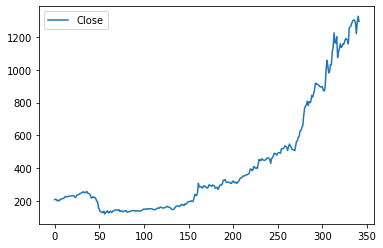

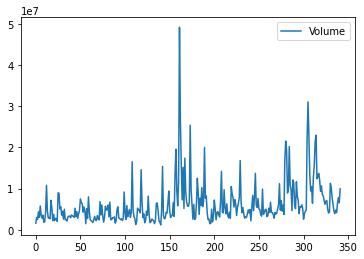

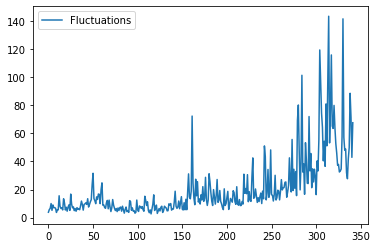

In [9]:
df.plot(y="Close")
df.plot(y="Volume")
df.plot(y="Fluctuations")

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


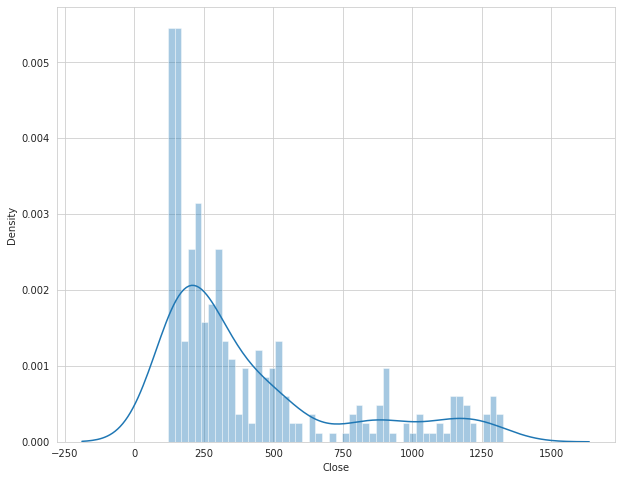

In [10]:
plt.figure(figsize=(10,8)) 
sns.set_style('whitegrid')
sns.distplot(df['Close'], bins=50, kde=True);

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


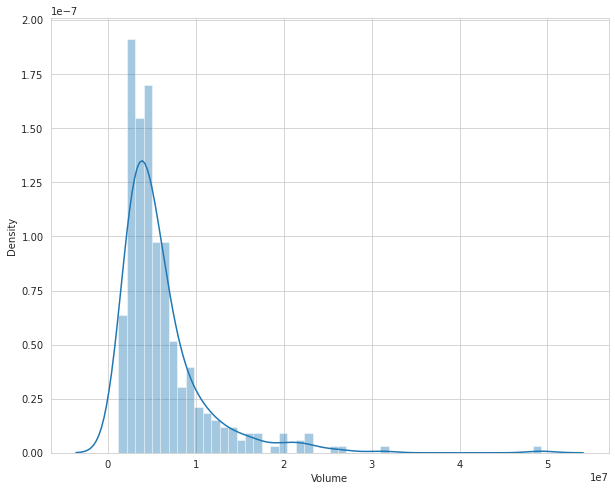

In [11]:
plt.figure(figsize=(10,8)) 
sns.set_style('whitegrid')
sns.distplot(df['Volume'], bins=50, kde=True);

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


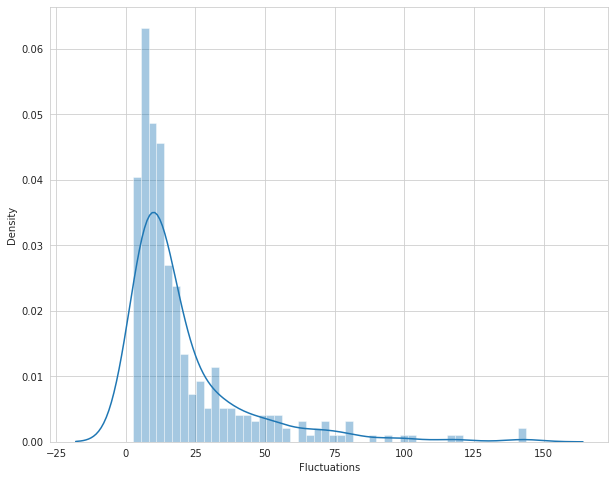

In [12]:
plt.figure(figsize=(10,8)) 
sns.set_style('whitegrid')
sns.distplot(df['Fluctuations'], bins=50, kde=True);

In [13]:
print(df['Daily Log Returns'].std()) # High volatile share

0.03508456250970593


Creating more features such as :
   1. 21 days moving average
   2. 7 days moving average
   3. 21 days exponential moving average - weighted average ( more weight to recent price)
   
 Then creating bollinger bands ( bands 2 standard deviation away from 21 days moving average ). Anything away from it is an outlier. This is done for Closing Price, Volume and Fluctuations. 
 

In [14]:
def get_technical_indicators(dataset):
    # Create 21 days Moving Average
    dataset['ma21_Close'] = dataset['Close'].rolling(window=21).mean()
    dataset['ma7_Close'] = dataset['Close'].rolling(window=7).mean()

    # Create Bollinger Bands
    dataset['21sd'] = dataset['Close'].rolling(window=21).std()
    dataset['upper_band'] = dataset['ma21_Close'] + (dataset['21sd']*2)
    dataset['lower_band'] = dataset['ma21_Close'] - (dataset['21sd']*2)

    # Create MACD
    dataset['ema21_Close'] = dataset['Close'].ewm(span=21).mean()

    dataset.drop('21sd',axis=1,inplace=True)

    return dataset

df = get_technical_indicators(df)
df.head()

,Date,High,Low,Close,Volume,Fluctuations,Daily Log Returns,Lag1,Lag2,Lag3,Lag4,Lag5,ma21_Close,ma7_Close,upper_band,lower_band,ema21_Close
0,2020-01-01,210.449997,206.649994,207.850006,1553127,3.800003,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,207.850006
1,2020-01-02,213.199997,207.500000,211.199997,2991937,5.699997,0.015989,3.349991,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,209.604763
2,2020-01-03,212.350006,205.800003,208.300003,2512421,6.550003,-0.013826,-2.899994,0.449997,NaN,NaN,NaN,NaN,NaN,NaN,NaN,209.127797
3,2020-01-06,207.750000,197.750000,199.550003,4353179,10.000000,-0.042915,-8.750000,-11.649994,-8.300003,NaN,NaN,NaN,NaN,NaN,NaN,206.380965
4,2020-01-07,205.699997,200.550003,204.050003,2966120,5.149994,0.022300,4.500000,-4.250000,-7.149994,-3.800003,NaN,NaN,NaN,NaN,NaN,205.821964


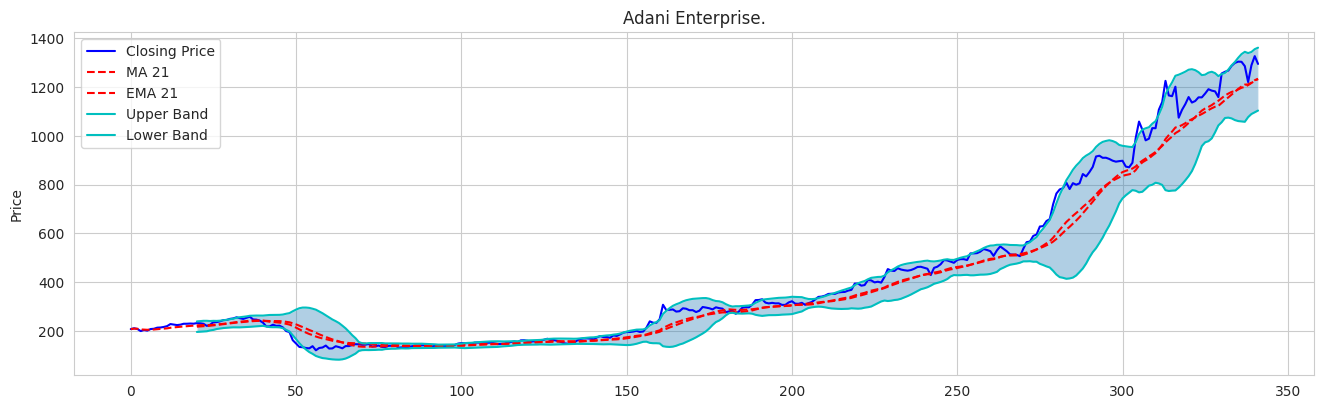

In [15]:
def plot_technical_indicators(dataset, last_days):
    plt.figure(figsize=(16, 10), dpi=100)
    shape_0 = dataset.shape[0]
    xmacd_ = shape_0-last_days
    dataset = dataset.iloc[-last_days:, :]
    x_ = range(3, dataset.shape[0])
    x_ =list(dataset.index)
    plt.subplot(2, 1, 1)
    plt.plot(dataset['Close'],label='Closing Price', color='b')
    plt.plot(dataset['ma21_Close'],label='MA 21', color='r',linestyle='--')
    plt.plot(dataset['ema21_Close'],label='EMA 21', color='r',linestyle='--')
    plt.plot(dataset['upper_band'],label='Upper Band', color='c')
    plt.plot(dataset['lower_band'],label='Lower Band', color='c')
    plt.fill_between(x_, dataset['lower_band'], dataset['upper_band'], alpha=0.35)
    plt.title('Adani Enterprise.')
    plt.ylabel('Price')
    plt.legend()  
   
    plt.show()
    
plot_technical_indicators(df, 365)

Boxplot of 7 days moving average of closing price and month. I have split dataframe into 2 in terms of year.

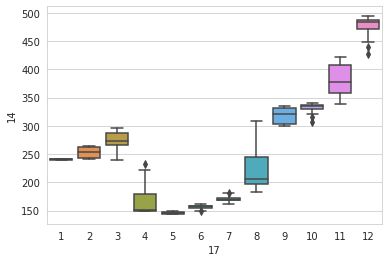

In [16]:
df['Date'] = pd.to_datetime(df.Date, format='%Y-%m-%d')
df['Month'] = df['Date'].dt.month
df['Year'] = df['Date'].dt.year
df1 = pd.DataFrame()
df2 = pd.DataFrame()
df1=pd.DataFrame(df[df['Year']== 2020].values.tolist()) 
df2=pd.DataFrame(df[df['Year']== 2021].values.tolist())
sns.boxplot(x=df1[17],y=df1[14])        # 17th column is month and 14th column is 7 days moving average
df1.head()
df.drop('Month', axis=1, inplace=True)
df.drop('Year', axis=1, inplace=True)

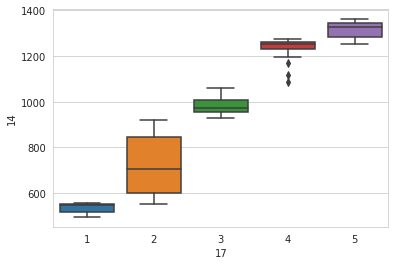

In [17]:
sns.boxplot(x=df2[17],y=df2[14])

Storing anomalies from bollinger bands for closing price in another dataframe then analyzing

In [18]:
df11=pd.DataFrame()
df11=pd.DataFrame(df[(df['Close']>df['upper_band']) | (df['Close']<df['lower_band'])].values.tolist())
df.drop('upper_band',axis=1,inplace=True)
df.drop('lower_band',axis=1,inplace=True)
df11.shape[0]

53

Doing the same thing for volume but not adding 7 days moving average of volume.

In [19]:
def get_technical_indicators(dataset):
    # Create 21 days Moving Average
    dataset['ma21_Volume'] = dataset['Volume'].rolling(window=21).mean()

    # Create Bollinger Bands
    dataset['21sd'] = dataset['Volume'].rolling(window=21).std()
    dataset['upper_band'] = dataset['ma21_Volume'] + (dataset['21sd']*2)
    dataset['lower_band'] = dataset['ma21_Volume'] - (dataset['21sd']*2)

    # Create MACD
    dataset['ema21_Volume'] = dataset['Volume'].ewm(span=21).mean()

    dataset.drop('21sd',axis=1,inplace=True)

    return dataset

df = get_technical_indicators(df)
df.head()

,Date,High,Low,Close,Volume,Fluctuations,Daily Log Returns,Lag1,Lag2,Lag3,Lag4,Lag5,ma21_Close,ma7_Close,ema21_Close,ma21_Volume,upper_band,lower_band,ema21_Volume
0,2020-01-01,210.449997,206.649994,207.850006,1553127,3.800003,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,207.850006,NaN,NaN,NaN,1.553127e+06
1,2020-01-02,213.199997,207.500000,211.199997,2991937,5.699997,0.015989,3.349991,NaN,NaN,NaN,NaN,NaN,NaN,209.604763,NaN,NaN,NaN,2.306789e+06
2,2020-01-03,212.350006,205.800003,208.300003,2512421,6.550003,-0.013826,-2.899994,0.449997,NaN,NaN,NaN,NaN,NaN,209.127797,NaN,NaN,NaN,2.381960e+06
3,2020-01-06,207.750000,197.750000,199.550003,4353179,10.000000,-0.042915,-8.750000,-11.649994,-8.300003,NaN,NaN,NaN,NaN,206.380965,NaN,NaN,NaN,2.947289e+06
4,2020-01-07,205.699997,200.550003,204.050003,2966120,5.149994,0.022300,4.500000,-4.250000,-7.149994,-3.800003,NaN,NaN,NaN,205.821964,NaN,NaN,NaN,2.951805e+06


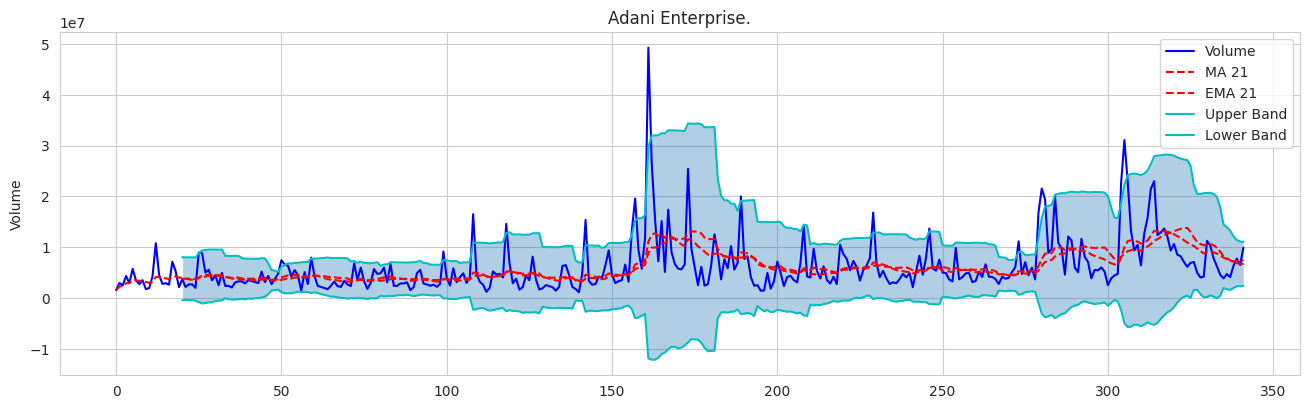

In [20]:
def plot_technical_indicators(dataset, last_days):
    plt.figure(figsize=(16, 10), dpi=100)
    shape_0 = dataset.shape[0]
    xmacd_ = shape_0-last_days
    dataset = dataset.iloc[-last_days:, :]
    x_ = range(3, dataset.shape[0])
    x_ =list(dataset.index)
    plt.subplot(2, 1, 1)
    plt.plot(dataset['Volume'],label='Volume', color='b')
    plt.plot(dataset['ma21_Volume'],label='MA 21', color='r',linestyle='--')
    plt.plot(dataset['ema21_Volume'],label='EMA 21', color='r',linestyle='--')
    plt.plot(dataset['upper_band'],label='Upper Band', color='c')
    plt.plot(dataset['lower_band'],label='Lower Band', color='c')
    plt.fill_between(x_, dataset['lower_band'], dataset['upper_band'], alpha=0.35)
    plt.title('Adani Enterprise.')
    plt.ylabel('Volume')
    plt.legend()  
   
    plt.show()
    
plot_technical_indicators(df, 365)

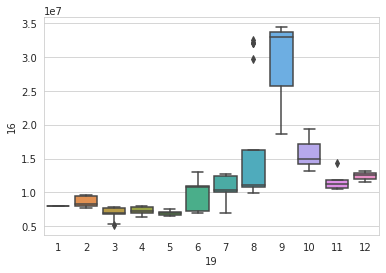

In [21]:
df['Month'] = df['Date'].dt.month
df['Year'] = df['Date'].dt.year
df1 = pd.DataFrame()
df2 = pd.DataFrame()
df1=pd.DataFrame(df[df['Year']== 2020].values.tolist()) 
df2=pd.DataFrame(df[df['Year']== 2021].values.tolist())
sns.boxplot(x=df1[19],y=df1[16])        # 19th column is month and 16th column is 21 days moving average
df1.head()
df.drop('Month', axis=1, inplace=True)
df.drop('Year', axis=1, inplace=True)

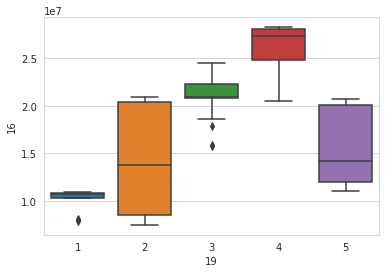

In [22]:
sns.boxplot(x=df2[19],y=df2[16])

In [23]:
df21=pd.DataFrame()
df21=pd.DataFrame(df[(df['Volume']>df['upper_band']) | (df['Volume']<df['lower_band'])].values.tolist())
df.drop('upper_band',axis=1,inplace=True)
df.drop('lower_band',axis=1,inplace=True)
df21.shape[0]

20

Doing same thing for fluctuations as volume

In [24]:
def get_technical_indicators(dataset):
    # Create 21 days Moving Average
    dataset['ma21_Fluctuations'] = dataset['Fluctuations'].rolling(window=21).mean()

    # Create Bollinger Bands
    dataset['21sd'] = dataset['Fluctuations'].rolling(window=21).std()
    dataset['upper_band'] = dataset['ma21_Fluctuations'] + (dataset['21sd']*2)
    dataset['lower_band'] = dataset['ma21_Fluctuations'] - (dataset['21sd']*2)

    # Create MACD
    dataset['ema21_Fluctuations'] = dataset['Fluctuations'].ewm(span=21).mean()

    dataset.drop('21sd',axis=1,inplace=True)

    return dataset

df = get_technical_indicators(df)
df.head()

,Date,High,Low,Close,Volume,Fluctuations,Daily Log Returns,Lag1,Lag2,Lag3,Lag4,Lag5,ma21_Close,ma7_Close,ema21_Close,ma21_Volume,ema21_Volume,ma21_Fluctuations,upper_band,lower_band,ema21_Fluctuations
0,2020-01-01,210.449997,206.649994,207.850006,1553127,3.800003,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,207.850006,NaN,1.553127e+06,NaN,NaN,NaN,3.800003
1,2020-01-02,213.199997,207.500000,211.199997,2991937,5.699997,0.015989,3.349991,NaN,NaN,NaN,NaN,NaN,NaN,209.604763,NaN,2.306789e+06,NaN,NaN,NaN,4.795238
2,2020-01-03,212.350006,205.800003,208.300003,2512421,6.550003,-0.013826,-2.899994,0.449997,NaN,NaN,NaN,NaN,NaN,209.127797,NaN,2.381960e+06,NaN,NaN,NaN,5.436708
3,2020-01-06,207.750000,197.750000,199.550003,4353179,10.000000,-0.042915,-8.750000,-11.649994,-8.300003,NaN,NaN,NaN,NaN,206.380965,NaN,2.947289e+06,NaN,NaN,NaN,6.745422
4,2020-01-07,205.699997,200.550003,204.050003,2966120,5.149994,0.022300,4.500000,-4.250000,-7.149994,-3.800003,NaN,NaN,NaN,205.821964,NaN,2.951805e+06,NaN,NaN,NaN,6.362813


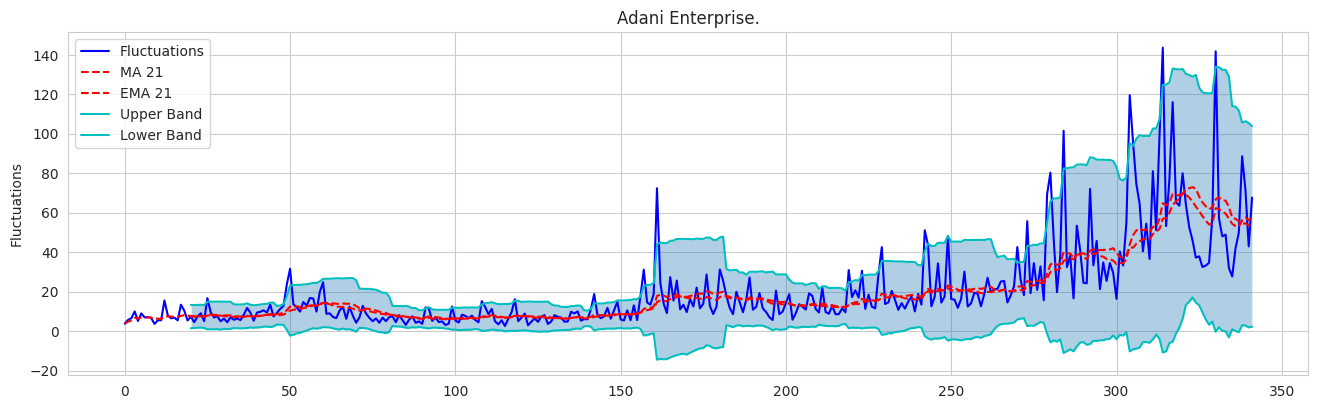

In [25]:
def plot_technical_indicators(dataset, last_days):
    plt.figure(figsize=(16, 10), dpi=100)
    shape_0 = dataset.shape[0]
    xmacd_ = shape_0-last_days
    dataset = dataset.iloc[-last_days:, :]
    x_ = range(3, dataset.shape[0])
    x_ =list(dataset.index)
    plt.subplot(2, 1, 1)
    plt.plot(dataset['Fluctuations'],label='Fluctuations', color='b')
    plt.plot(dataset['ma21_Fluctuations'],label='MA 21', color='r',linestyle='--')
    plt.plot(dataset['ema21_Fluctuations'],label='EMA 21', color='r',linestyle='--')
    plt.plot(dataset['upper_band'],label='Upper Band', color='c')
    plt.plot(dataset['lower_band'],label='Lower Band', color='c')
    plt.fill_between(x_, dataset['lower_band'], dataset['upper_band'], alpha=0.35)
    plt.title('Adani Enterprise.')
    plt.ylabel('Fluctuations')
    plt.legend()  
   
    plt.show()
    
plot_technical_indicators(df, 365)

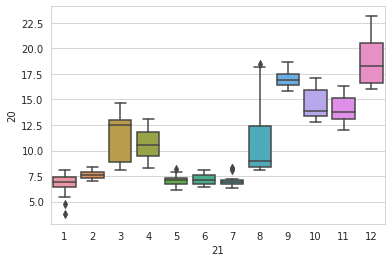

In [26]:
df['Month'] = df['Date'].dt.month
df['Year'] = df['Date'].dt.year
df1 = pd.DataFrame()
df2 = pd.DataFrame()
df1=pd.DataFrame(df[df['Year']== 2020].values.tolist()) 
df2=pd.DataFrame(df[df['Year']== 2021].values.tolist())
sns.boxplot(x=df1[21],y=df1[20])        # 17th column is month and 15th column is 21 days moving average
df1.head()
df.drop('Month', axis=1, inplace=True)
df.drop('Year', axis=1, inplace=True)

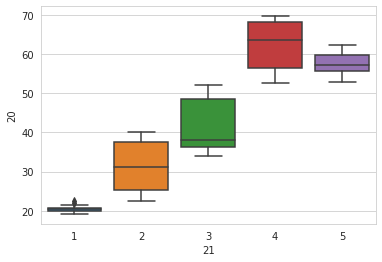

In [27]:
sns.boxplot(x=df2[21],y=df2[20])

In [28]:
df31=pd.DataFrame()
df31=pd.DataFrame(df[(df['Fluctuations']>df['upper_band']) | (df['Fluctuations']<df['lower_band'])].values.tolist())
df.drop('upper_band',axis=1,inplace=True)
df.drop('lower_band',axis=1,inplace=True)
df31.shape[0]

24

The Commodity Channel Index (CCI) is a technical indicator that measures the difference between the current price and the historical average price. When the CCI is above zero, it indicates the price is above the historic average. Conversely, when the CCI is below zero, the price is below the historic average.

CCI = (Typical Price - 20 days MA of TP) / (. 015 x Mean Deviation) 

Typical Price (TP) = (High + Low + Close)/3 

Mean Deviation = [Σ |X – µ|]/N

It is somewhat similat to bollinger bands.

In [29]:
#momentum based oscillator to determine the price current trend w.r.t to previous trends
df['TP'] = (df['High'] + df['Low'] + df['Close']) / 3 
df['sma'] = df['TP'].rolling(21).mean()
df['mad'] = df['TP'].rolling(21).apply(lambda x: pd.Series(x).mad())
df['CCI'] = (df['TP'] - df['sma']) / (0.015 * df['mad']) 
df.drop('High',axis=1,inplace=True)
df.drop('Low',axis=1,inplace=True)
df.drop('TP',axis=1,inplace=True)
df.drop('sma',axis=1,inplace=True)
df.drop('mad',axis=1,inplace=True)
df.head()

,Date,Close,Volume,Fluctuations,Daily Log Returns,Lag1,Lag2,Lag3,Lag4,Lag5,ma21_Close,ma7_Close,ema21_Close,ma21_Volume,ema21_Volume,ma21_Fluctuations,ema21_Fluctuations,CCI
0,2020-01-01,207.850006,1553127,3.800003,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,207.850006,NaN,1.553127e+06,NaN,3.800003,NaN
1,2020-01-02,211.199997,2991937,5.699997,0.015989,3.349991,NaN,NaN,NaN,NaN,NaN,NaN,209.604763,NaN,2.306789e+06,NaN,4.795238,NaN
2,2020-01-03,208.300003,2512421,6.550003,-0.013826,-2.899994,0.449997,NaN,NaN,NaN,NaN,NaN,209.127797,NaN,2.381960e+06,NaN,5.436708,NaN
3,2020-01-06,199.550003,4353179,10.000000,-0.042915,-8.750000,-11.649994,-8.300003,NaN,NaN,NaN,NaN,206.380965,NaN,2.947289e+06,NaN,6.745422,NaN
4,2020-01-07,204.050003,2966120,5.149994,0.022300,4.500000,-4.250000,-7.149994,-3.800003,NaN,NaN,NaN,205.821964,NaN,2.951805e+06,NaN,6.362813,NaN


We have taken the assumption that nearly 10% of the values in the dataset are outliers for fine tuning the model.

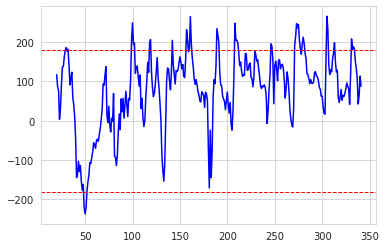

In [30]:
plt.plot(df['CCI'], color = 'blue')
plt.axhline(180, linestyle = '--', linewidth = 1, color = 'red')
plt.axhline(-180, linestyle = '--', linewidth = 1, color = 'red')
plt.show()

In [31]:
df12=pd.DataFrame()
df12=pd.DataFrame(df[(df['CCI']>180) | (df['CCI']<-180)].values.tolist())
df12.shape[0]

43

In [32]:
print(pd.merge(df11, df12, on=0).shape[0]) 
df12.set_index(0,inplace=True)
df11_12 = pd.concat([df11,df12]).reset_index()
df11_12=df11_12.drop_duplicates(subset=0)
df11_12.shape[0]

35


54

Most coomon anomaly

Share Bashing - False and/or misleading information about the target company in an attempt to get shares for a cheaper price. This activity, in most cases, is conducted by posting libelous posts on multiple public forums. The perpetrators sometimes work directly for unscrupulous Investor Relations firms who have convertible notes that convert for more shares the lower the bid or ask price is; thus the lower these Bashers can drive a stock price down by trying to convince shareholders they have bought a worthless security, the more shares the Investor Relations firm receives as compensation. Immediately after the stock conversion is complete and shares are issued to the Investor Relations firm, consultant, attorney or similar party, the basher/s then become friends of the company and move quickly to ensure they profit on a classic Pump & Dump scheme to liquidate their ill-gotten shares. 


Means either the stock price will shoot up and volume of share shoots up then it indicates an anomaly else stock price drops suddenly and volume of share traded increases cause an anomaly. 

The closing price only not accounts for anomaly. 

So we will take all anomalies of closing price from bollinger bands and CCI index and volume anomaly from bollinger bands and take intersection of both, it will give us anomaly. 

Also it might happen that this anomaly persists for a day only and the share price closes normally. So we will take intersection of anomaly of volume and fluctuations as well.

In [33]:
df12.reset_index(0,inplace=True)
df21.reset_index(0,inplace=True)
df31.reset_index(0,inplace=True)

dmerge1 = pd.merge(df11_12, df21, on=0)
dmerge2 = pd.merge(df31, df21, on=0)
dmerge1.set_index(0,inplace=True)
dmerge2.set_index(0,inplace=True)
do1 = pd.concat([dmerge1,dmerge2]).reset_index()
do1 = do1.drop_duplicates(subset=0)
print(do1.shape[0])
do1.head()

18


,0,index_x,1_x,2_x,3_x,4_x,5_x,6_x,7_x,8_x,9_x,10_x,11_x,12_x,13_x,14_x,15_x,16_x,17_x,index_y,1_y,2_y,3_y,4_y,5_y,6_y,7_y,8_y,9_y,10_y,11_y,12_y,13_y,14_y,15_y,16_y,17_y,18,18_x,19,20,18_y
0,2020-03-13,7,161.350006,129.750000,148.750000,7463176.0,31.600006,-0.086255,-13.399994,-47.000000,-50.949997,-66.000000,-73.000000,227.119046,194.850000,287.685269,166.552823,213.862019,NaN,1,161.350006,129.750000,148.750000,7463176,31.600006,-0.086255,-13.399994,-47.000000,-50.949997,-66.000000,-73.000000,227.119046,194.850000,213.862019,3.631099e+06,6.115018e+06,1.147180e+06,4.071253e+06,NaN,NaN,NaN,NaN
1,2020-03-16,8,142.300003,128.649994,134.699997,6582749.0,13.650009,-0.099217,-14.050003,-27.449997,-61.050003,-65.000000,-80.050003,221.642856,182.507141,293.396540,149.889171,206.614448,NaN,2,142.300003,128.649994,134.699997,6582749,13.650009,-0.099217,-14.050003,-27.449997,-61.050003,-65.000000,-80.050003,221.642856,182.507141,206.614448,3.730739e+06,6.509759e+06,9.517181e+05,4.301189e+06,NaN,NaN,NaN,NaN
2,2020-05-29,10,153.600006,141.100006,148.350006,9162612.0,12.500000,0.039180,5.700012,7.350006,8.850006,10.250000,10.050003,138.969046,141.321431,146.594563,131.343530,140.672999,NaN,4,153.600006,141.100006,148.350006,9162612,12.500000,0.039180,5.700012,7.350006,8.850006,10.250000,10.050003,138.969046,141.321431,140.672999,3.731488e+06,7.502384e+06,-3.940687e+04,3.769610e+06,NaN,NaN,NaN,NaN
3,2020-06-25,12,169.199997,153.000000,161.649994,14608370.0,16.199997,0.043299,6.849991,4.449997,7.000000,8.949997,13.799988,151.166665,153.714284,159.274520,143.058810,150.851161,NaN,6,169.199997,153.000000,161.649994,14608370,16.199997,0.043299,6.849991,4.449997,7.000000,8.949997,13.799988,151.166665,153.714284,150.851161,5.119106e+06,1.282490e+07,-2.586689e+06,5.230285e+06,NaN,NaN,NaN,NaN
4,2020-07-29,15,190.850006,172.050003,179.100006,15392378.0,18.800003,0.031479,5.550003,13.150009,10.350006,9.150009,9.700012,162.019047,170.571429,178.691704,145.346389,163.147623,NaN,7,190.850006,172.050003,179.100006,15392378,18.800003,0.031479,5.550003,13.150009,10.350006,9.150009,9.700012,162.019047,170.571429,163.147623,3.855587e+06,1.036905e+07,-2.657872e+06,4.616538e+06,NaN,NaN,NaN,NaN


Now we will use isolation forest.

Isolation forest randomly forms multiple decision trees to form a forest and gives score according to -
 
      s(x) = 2 pow (-E(h(x))/c(n))
      
E(h(x)) = average path length of all trees

c(n) = 2*H(n-1) - 2*(n-1)/n            (can be easily proved by graphs data structure)

It gives us mostly global anomalies. We are using 3 features Close, Volume, Fluctuations.

It mostly gives global features but sometimes gives local anomalies as well. We have taken lag of 5 days so only using global outlier function foe lag such as HBOS.

In [34]:
x=pd.DataFrame(df[['Close','Volume','Fluctuations']])
clf=IsolationForest(n_estimators=100, max_samples='auto',contamination=float(.1),max_features=x.shape[1], bootstrap=False, n_jobs=-1, random_state=42, verbose=0)
clf.fit(x)
pred = clf.predict(x)
df['anomaly']=pred
outliers=df.loc[df['anomaly']==-1]
df1233=pd.DataFrame()
df1233=pd.DataFrame(outliers.values.tolist())
df.drop('anomaly',axis=1,inplace=True)
df1233.shape

(35, 19)

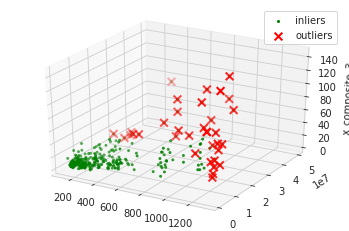

In [35]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.set_zlabel("x_composite_3")

ax.scatter(df['Close'], df['Volume'], zs=df['Fluctuations'], s=4, lw=1, label="inliers",c="green")

ax.scatter(df1233[1],df1233[2], df1233[3],
           lw=2, s=60, marker="x", c="red", label="outliers")
ax.legend()
plt.show()

It can be easily visualized above that all outliers are are global outliers and we can also set the threshold by observing.

We can observe below a high Correlation between close and fluctuations

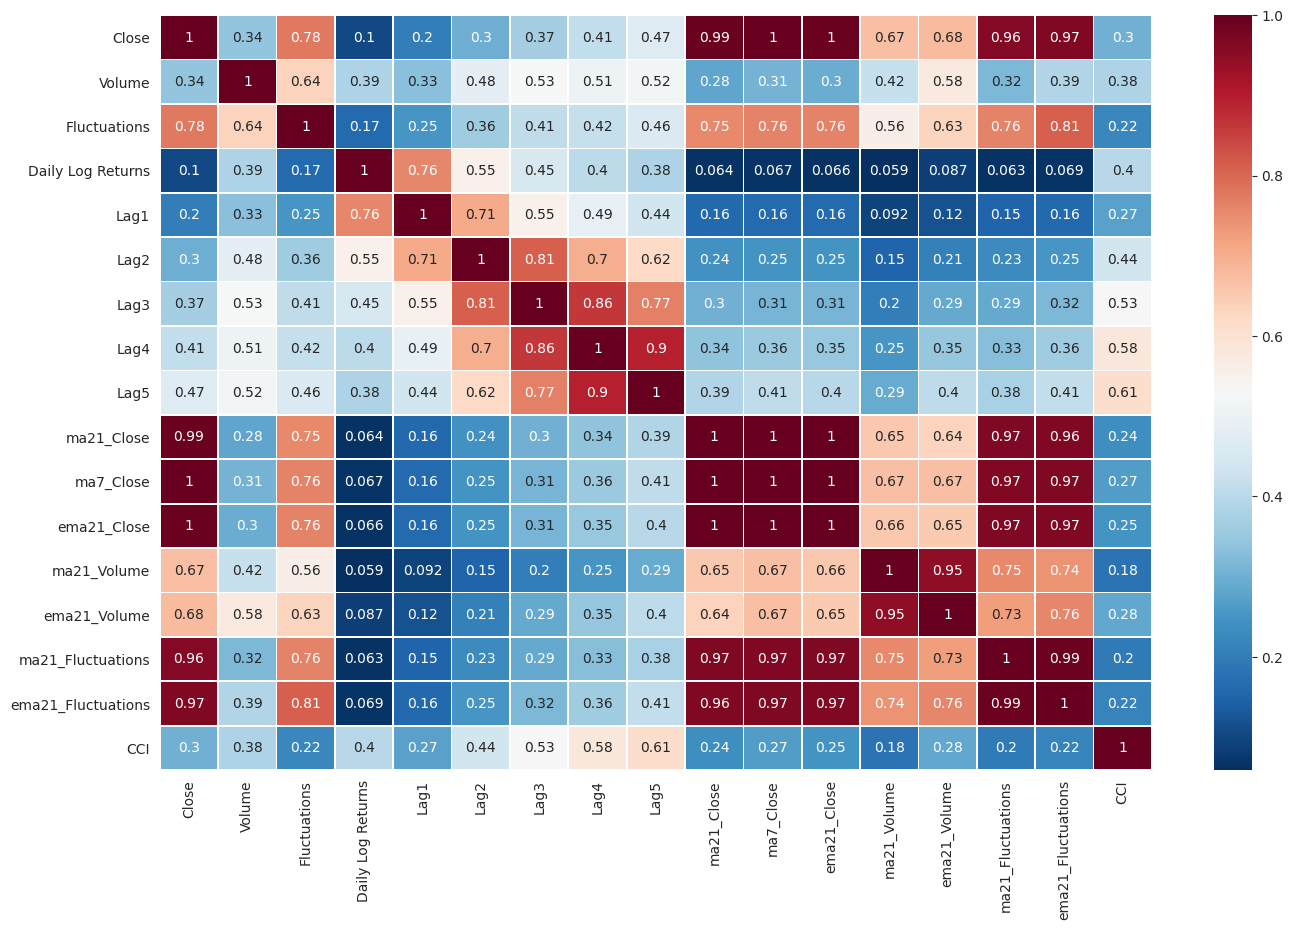

In [36]:
corr = df.corr()
plt.figure(figsize=(16, 10), dpi=100)
sns.heatmap(corr, xticklabels=corr.columns,yticklabels=corr.columns,cmap='RdBu_r',annot=True,linewidth=0.5)

GESD (Generalized Extreme Studentized Deviate) -  The GESD test only requires that an upper bound for the suspected number of outliers be specified.
Given the upper bound, r, the generalized ESD test essentially performs r separate tests: a test for one outlier, a test for two outliers, and so on up to r outliers.

The generalized ESD test is defined for the hypothesis:

H0: There are no outliers in the data set

Ha: There are up to r outliers in the data set

Our test statistic is given by the formula below:

            R = max|xi - x_bar| / standard deviation

In GESD we remove the observation that maximizes |xi — x_bar| and then recompute the above statistic with n-1 observations. We repeat this process until r observations have been removed. This results in the r statistics R1, R2 ………., Rr. 

Corresponding to the r test statistics, compute the following r critical values:

               λi= ((n−i) * t (p,n−i−1)) / root ((n−i−1+t(p,n−i−1)*t(p,n−i−1))(n−i+1))



In [37]:
def test_stat(y, iteration):
    std_dev = np.std(y)
    avg_y = np.mean(y)
    abs_val_minus_avg = abs(y - avg_y)
    max_of_deviations = max(abs_val_minus_avg)
    max_ind = np.argmax(abs_val_minus_avg)
    cal = max_of_deviations/ std_dev
    print('Test {}'.format(iteration))
    print("Test Statistics Value(R{}) : {}".format(iteration,cal))
    return cal, max_ind

def calculate_critical_value(size, alpha, iteration):
    t_dist = stats.t.ppf(1 - alpha / (2 * size), size - 2)
    numerator = (size - 1) * np.sqrt(np.square(t_dist))
    denominator = np.sqrt(size) * np.sqrt(size - 2 + np.square(t_dist))
    critical_value = numerator / denominator
    print("Critical Value(λ{}): {}".format(iteration, critical_value))
    return critical_value

def check_values(R, C, inp, max_index, iteration):
    if R > C:
        print('{} is an outlier. R{} > λ{}: {:.4f} > {:.4f} \n'.format(inp[max_index],iteration, iteration, R, C))
    else:
        print('{} is not an outlier. R{}> λ{}: {:.4f} > {:.4f} \n'.format(inp[max_index],iteration, iteration, R, C))

def ESD_Test(input_series, alpha, max_outliers):
    stats = []
    critical_vals = []
    for iterations in range(1, max_outliers + 1):
        stat, max_index = test_stat(input_series, iterations)
        critical = calculate_critical_value(len(input_series), alpha, iterations)
        check_values(stat, critical, input_series, max_index, iterations)
        input_series = np.delete(input_series, max_index)
        critical_vals.append(critical)
        stats.append(stat)
        if stat > critical:
            max_i = iterations
    print('H0:  there are no outliers in the data')
    print('Ha:  there are up to 30 outliers in the data')
    print('')
    print('Significance level:  α = {}'.format(alpha))
    print('Critical region:  Reject H0 if Ri > critical value')
    print('Ri: Test statistic')
    print('λi: Critical Value')
    print(' ')

x=np.array(df['Close'])
ESD_Test(x, 0.05, 30)

Test 1
Test Statistics Value(R1) : 2.7583264325287025
Critical Value(λ1): 3.7602390599327262
1326.699951171875 is not an outlier. R1> λ1: 2.7583 > 3.7602 

Test 2
Test Statistics Value(R2) : 2.7247149097350207
Critical Value(λ2): 3.7594263142134867
1304.0999755859375 is not an outlier. R2> λ2: 2.7247 > 3.7594 

Test 3
Test Statistics Value(R3) : 2.7571580358353867
Critical Value(λ3): 3.758610862817888
1303.5 is not an outlier. R3> λ3: 2.7572 > 3.7586 

Test 4
Test Statistics Value(R4) : 2.7783929509067056
Critical Value(λ4): 3.7577926883926085
1298.9000244140625 is not an outlier. R4> λ4: 2.7784 > 3.7578 

Test 5
Test Statistics Value(R5) : 2.8016226434636398
Critical Value(λ5): 3.7569717734200845
1294.699951171875 is not an outlier. R5> λ5: 2.8016 > 3.7570 

Test 6
Test Statistics Value(R6) : 2.8212425818159574
Critical Value(λ6): 3.7561481002159676
1289.0999755859375 is not an outlier. R6> λ6: 2.8212 > 3.7561 

Test 7
Test Statistics Value(R7) : 2.8519653573290578
Critical Value(λ7):

GESD test dosen't gave any outliers the reason being it is valid only for normal distribution. But the closing price don't follow normal distribution at all which we can prove by shapiro test. 

The Shapiro-Wilk test is a way to tell if a random sample comes from a normal distribution. The test gives you a W value; small values indicate your sample is not normally distributed (you can reject the null hypothesis that your population is normally distributed if your values are under a certain threshold). The cut off value is calculated by monte carlo simulations.

                 

In [38]:
shapiro(df['Close'])

(0.7826777696609497, 5.1037601172083e-21)

Now we will use DBSCAN with features Close, Volume and Fluctuations. 

DBSCAN - It is a clustering algorithm which uses minimum samples near to core point and distance from core point to find the clusters of values and find the outliers. It is used for global outliers. 

Normal practice is to choose minimum samples to be 2*dimension and distance by how much number of outliers you want.

In [39]:
min_max_scaler = MinMaxScaler()
x=pd.DataFrame(df[['Close','Volume','Fluctuations']])
x[["Close", "Volume", "Fluctuations"]] = min_max_scaler.fit_transform(x[["Close", "Volume", "Fluctuations"]])
model = DBSCAN(eps = 0.15, min_samples = 6).fit(x)
print(model.labels_)

[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0 -1  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0 -1 -1 -1  0  0 -1  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0 -1 -1 -1  0  0  0  0  0
  0 -1 -1  0  0 -1  0  0  0  0  0  0  0  0  0  0  0

In [40]:
df['anomaly'] = model.labels_
df1234=pd.DataFrame()
df1234=pd.DataFrame(df[df['anomaly']==-1])
df.drop('anomaly', axis=1, inplace =True)
df1234.shape[0]

12

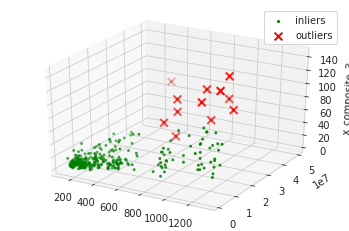

In [41]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.set_zlabel("x_composite_3")

ax.scatter(df['Close'], df['Volume'], zs=df['Fluctuations'], s=4, lw=1, label="inliers",c="green")

ax.scatter(df1234['Close'],df1234['Volume'], df1234['Fluctuations'],
           lw=2, s=60, marker="x", c="red", label="outliers")
ax.legend()
plt.show()

Now we will use HBOS ( Histogram based outlier selection ) with features Close, Volume, Fluctuations, Lag1, Lag2, Lag3, Lag4, Lag5 because this method is proximity based (outlier when locality is sparse) method detecting only global outliers.
Also we used mode of the column to fill NaN values.

HBOS - For multivariate analysis it plots histogram for all individual features and do combined scoring based on the height of individual bins. If the score is higher than threshold value is considered as an outlier.

In [42]:
x=pd.DataFrame(df[['Close','Volume','Fluctuations','Lag1', 'Lag2', 'Lag3','Lag4','Lag5']])
x[['Close','Volume','Fluctuations','Lag1', 'Lag2', 'Lag3','Lag4','Lag5']] = min_max_scaler.fit_transform(x[['Close','Volume','Fluctuations','Lag1', 'Lag2', 'Lag3','Lag4','Lag5']])
hbos = HBOS(n_bins=100)
x=x.fillna(x.mode().iloc[0])
hbos.fit(x)
HBOS(alpha=0.1, contamination=0.1, n_bins=20, tol=0.5)
output = hbos.decision_function(x)

In [43]:
df['anomaly'] = hbos.predict(x)
dfo2=pd.DataFrame()
dfo2=pd.DataFrame(df[df['anomaly']==1])
df.drop('anomaly', axis=1, inplace =True)
dfo2.shape[0]

35

We can observe that all the outliers from this are coming from - 

1. Close = (600 - 1200)
2. Volume = greater than 0.2*e8
3. Fluctuations = greater than 70
4. Lag1 = Less than -50 and greater than 50
5. Lag2 = Less than -40 and greater than 70 
6. Lag3 = Less than -50 and greater than 100
7. Lag4 = Less than -50 and greater than 100
8. Lag5 = Less than -50 and greater than 100

These bins are responsible for high scores. We can visualize by plotting histogram of each feature. 

In [44]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):  
    print(dfo2)

          Date        Close    Volume  Fluctuations  Daily Log Returns  \
49  2020-03-12   162.149994   4834390     23.449997          -0.188317   
50  2020-03-13   148.750000   7463176     31.600006          -0.086255   
157 2020-08-19   239.550003  19592028     31.149994           0.114189   
161 2020-08-25   307.549988  49264537     72.399994           0.212390   
189 2020-10-05   326.600006  20009492     27.149994           0.058150   
242 2020-12-21   429.200012   5350194     51.100006          -0.058704   
273 2021-02-04   589.700012  11184167     55.700012           0.039960   
275 2021-02-08   628.299988   7085276     34.450012           0.053868   
277 2021-02-10   650.700012   5991927     32.800049           0.032567   
279 2021-02-12   718.950012  16810897     69.250000           0.087675   
280 2021-02-15   763.450012  21579566     80.299988           0.060056   
281 2021-02-16   780.200012  19426061     46.700012           0.021703   
288 2021-02-25   843.500000  12118095 

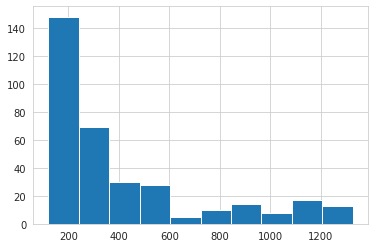

In [45]:
df['Close'].hist()

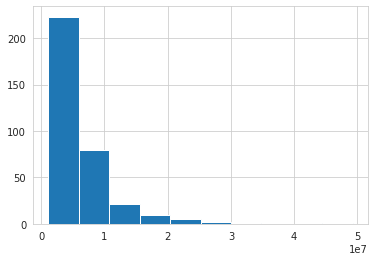

In [46]:
df['Volume'].hist()

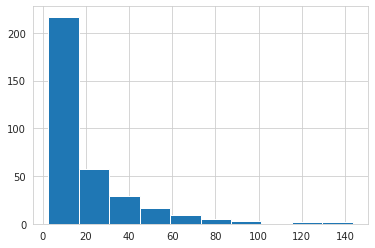

In [47]:
df['Fluctuations'].hist()

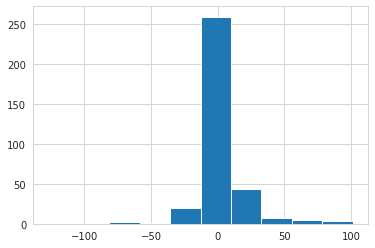

In [48]:
df['Lag1'].hist()

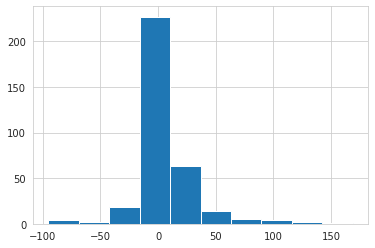

In [49]:
df['Lag2'].hist()

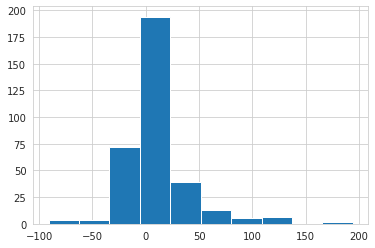

In [50]:
df['Lag3'].hist()

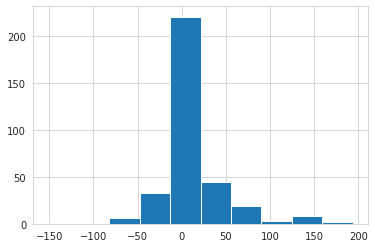

In [51]:
df['Lag4'].hist()

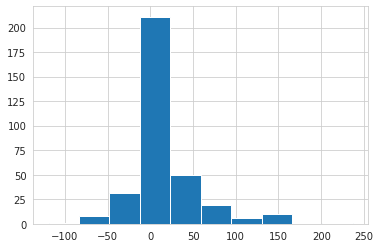

In [52]:
df['Lag5'].hist()

Now we will use Local outlier factor for local anomalies. It measures the local deviation of density of a given sample with respect to its neighbors.
We will use Close, Volume and Fluctuations as the feature for it.


In [53]:
clf = LocalOutlierFactor(n_neighbors=2,contamination=float(.1))
x=pd.DataFrame(df[['Close','Volume','Fluctuations']])
x[["Close", "Volume", "Fluctuations"]] = min_max_scaler.fit_transform(x[["Close", "Volume", "Fluctuations"]])
x=np.array(x)
df['anomaly'] = clf.fit_predict(x)

df1236=pd.DataFrame(df[df['anomaly']==-1])
df.drop('anomaly', axis=1, inplace =True)
df1236.shape

(35, 19)

We can easily visualize that it is giving local outliers 

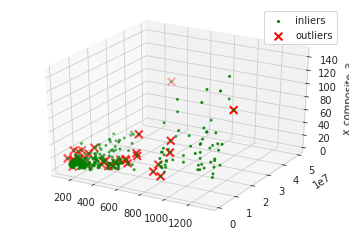

In [54]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.set_zlabel("x_composite_3")

ax.scatter(df['Close'], df['Volume'], zs=df['Fluctuations'], s=4, lw=1, label="inliers",c="green")

ax.scatter(df1236['Close'],df1236['Volume'], df1236['Fluctuations'],
           lw=2, s=60, marker="x", c="red", label="outliers")
ax.legend()
plt.show()

Now we will concat anomalies from all the algorithms into single dataframe

In [55]:
do1.rename(columns={0:'Date'}, inplace=True)
df1233.rename(columns={0:'Date'}, inplace=True)

dconcat1 = pd.concat([do1,df1233,df1234,dfo2,df1236]).reset_index()
dconcat1 = dconcat1.drop_duplicates(subset='Date')

dconcat1.shape                                       #This was (77,78) please check

(81, 78)

In [56]:
dcombined = pd.merge(df, dconcat1, on='Date')
dcombined = pd.DataFrame(dcombined[['Date','Close_x','Volume_x','Fluctuations_x']])

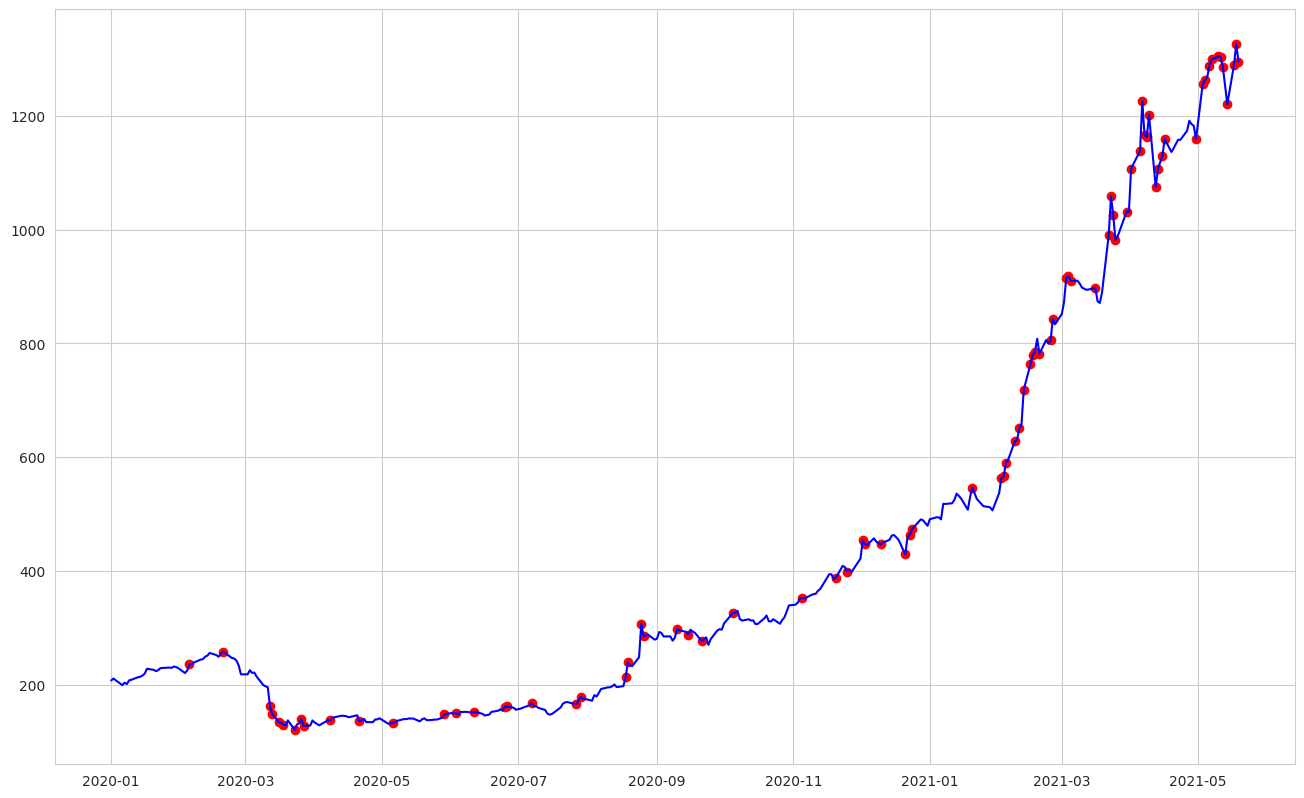

In [57]:
plt.figure(figsize=(16, 10), dpi=100)
plt.plot(df['Date'],df['Close'],color = 'b')
plt.scatter(x=dcombined['Date'], y=dcombined['Close_x'], color='r')

All anomalies are considered as point anomalies. That is the reason we have approx 20% anomalies from the total dataset. If we classify anomaly on the basis of continuous and point anomaly the count of anomalies will be in a reasonable number. 

Explanation for anomalies:

05-02-2020: The quarterly results for Adani Enterprise was announced on that day.The cmpany reported that it's profit has surged to over fourfold to Rs 382.98 crore in the December 2019 quarter.

12-03-2020 to 13-03-2020:The company on 11th March announced that said it has won a Rs 1,546-crore project from National Highways Authority of India (NHAI) for building a stretch of NH-16 in Andhra Pradesh under Bharatmala Pariyojana. 

12-3-2020 to 23-03-2020:dividend was announced on 12th March,2020 and the ex-date was 23th March,2020.

21-04-2020(21st April):The company resumed operations at its production facility, certain offices and few critical storage facilities from April 20, 2020 after obtaining necessary regulatory approvals and clearances.(in midst of the nation-wide lockwide)

06-05-2020(6th May 2020):(1)On 6th May, there was a board meeting for Audited Results & Others.The company reported a 63.57 per cent decline in consolidated profit to Rs 96.93 crore for the fourth quarter ended March 31.
(2)The company said said its board has given in principle approval to raise Rs 1,000 crore through NCDs(Non-Convertible Debentures) on private placement basis. The company also said that it will seek shareholders' nod for raising up to Rs 2,500 crore through QIP.

03-06-2020(3rd June,2020):On this day, the company reported that COVID-19 impact on operations are to be visible in next couple of quarters.

25-08-2020(25 th August,2020):The Kerala High Court on 25 th August declined to stay the further proceedings in leasing out Thiruvananthapuram international airport to Adani Enterprises.Considering an application by the Kerala government seeking the stay, the court adjourned the case for detailed hearing.

05-11-2020(5th Nov,2020):(1)Adani Group's flagship firm Adani Enterprises Ltd (AEL) plans to spend about Rs 50,000 crore in capital expenditure(capex) over the next five years with a major chunk of it going towards airports business, a top company official said on November 4.
(2)On 4th Nv there was a board meeting for publishing quarterly results.Turning profitable in the September quarter, Adani Enterprises on November 4 reported a quarterly consolidated profit of Rs 435.73 crore.The EBIDTA for the quarter increased by healthy 76 percent at Rs 951 crore owing to better volumes in mining services and solar manufacturing businesses.

03-02-2021(3rd February,2021):There was a board meeting for releasing quarterly results on 3rd February.Adani Enterprises reported a 10.39 percent fall in its consolidated profit to Rs 343.17 crore for the third quarter ended December 2020.

08-02-2021(8 Th February,2021):Adani Airport Holdings (AAHL), a wholly owned subsidiary of Adani Enterprises, has acquired 23.5 percent stake in Mumbai International Airport (MIAL) from ACSA Global (ACSA) and Bid Services Division (Mauritius), or Bidvest, for Rs 1,685.25 crore, the company informed exchanges on February 7.

24-02-2021/25-02-2021(24 rth February,2021):Adani Enterprises share price added over 2 percent in early trade on February 23 after the company formed a joint venture (JV) with EdgeConneX.The company in a press release said that it has an establishment of a 50:50 joint venture with EdgeConneX.

22-03-2021/23-03-2021/24-03-2021/25-03-2021:
(1)On March 19 the company announced its subsidiary Adani Road Transport Limited bagged a project in Gujarat under Toll Operate Transfer (TOT) mode.
(2)media reports suggested that Italian firm Maire Tecnimont S.p.A. said its arms NextChem, Stamicarbon and MET Development (MET DEV) have teamed up with Adani Enterprises to develop green hydrogen projects in India.
(3)the company's promotors, Gautam Adani and Rajesh Adani revoked 46,90,000 shares of Adani Entertainment on March 19, a BSE data released on March 22 showed.





In [58]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):  
    print(dcombined)

         Date      Close_x  Volume_x  Fluctuations_x
0  2020-02-05   236.250000   8985919       16.750000
1  2020-02-20   258.649994   3108173        8.350006
2  2020-03-12   162.149994   4834390       23.449997
3  2020-03-13   148.750000   7463176       31.600006
4  2020-03-16   134.699997   6582749       13.650009
5  2020-03-18   130.199997   4255688        9.900002
6  2020-03-23   120.900002   1456143       16.800003
7  2020-03-26   140.250000   7980255       19.949997
8  2020-03-27   128.000000   4378366       24.750000
9  2020-04-08   138.100006   3237290       12.250000
10 2020-04-21   135.949997   3576177        8.850006
11 2020-05-06   133.250000   6685480        8.099991
12 2020-05-29   148.350006   9162612       12.500000
13 2020-06-03   150.649994   5875845        8.299988
14 2020-06-11   151.800003  16533100       15.199997
15 2020-06-25   161.649994  14608370       16.199997
16 2020-06-26   162.149994   6772909        5.050003
17 2020-07-07   168.149994   8172143        7.

Let us now run the GESD test on the 'Lag1' feature.But for that first we need to make sure that the 'Lag1' feature is normally distributed.For this we would be doing the following 3 things----

1) Plotting Histogram of the feature

2)Plotting boxplot of the feature

3)Carrying out the Shapiro test.If the p-value of the test is greater than 0.05 (significance level) we can say that it has a normal distribution

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


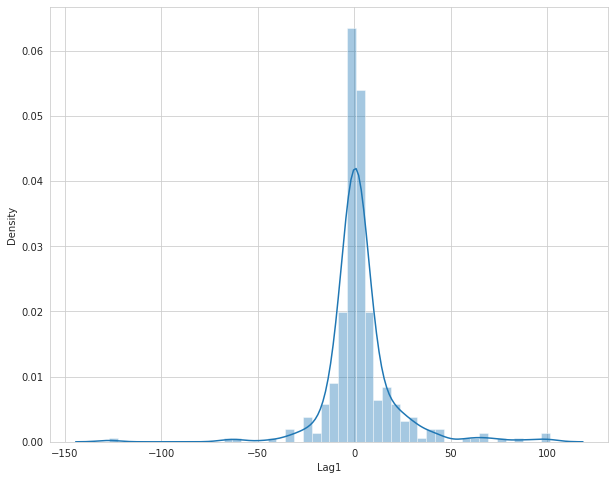

In [59]:
plt.figure(figsize=(10,8)) 
sns.set_style('whitegrid')
sns.distplot(df['Lag1'], bins=50, kde=True);

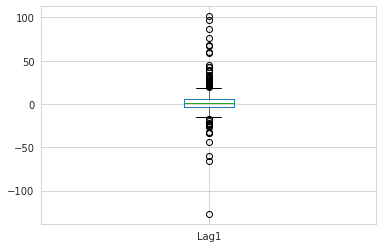

In [60]:
df['Lag1'].plot(kind='box')

In [61]:
from scipy import stats
statistic,pvalue = stats.shapiro(df['Lag1'])
print(pvalue)

1.0


Hence from all these normality tests df['Lag1'] can be inferred as a normal distribution.Now carrying out the gesd test on ['Lag1']

In [62]:
def test_stat(y, iteration):
    std_dev = np.std(y)
    avg_y = np.mean(y)
    abs_val_minus_avg = abs(y - avg_y)
    max_of_deviations = max(abs_val_minus_avg)
    max_ind = np.argmax(abs_val_minus_avg)
    cal = max_of_deviations/ std_dev
    print('Test {}'.format(iteration))
    print("Test Statistics Value(R{}) : {}".format(iteration,cal))
    return cal, max_ind

def calculate_critical_value(size, alpha, iteration):
    t_dist = stats.t.ppf(1 - alpha / (2 * size), size - 2)
    numerator = (size - 1) * np.sqrt(np.square(t_dist))
    denominator = np.sqrt(size) * np.sqrt(size - 2 + np.square(t_dist))
    critical_value = numerator / denominator
    print("Critical Value(λ{}): {}".format(iteration, critical_value))
    return critical_value

def check_values(R, C, inp, max_index, iteration):
    if R > C:
        print('{} is an outlier. R{} > λ{}: {:.4f} > {:.4f} \n'.format(inp[max_index],iteration, iteration, R, C))
    else:
        print('{} is not an outlier. R{}> λ{}: {:.4f} > {:.4f} \n'.format(inp[max_index],iteration, iteration, R, C))

def ESD_Test(input_series, alpha, max_outliers):
    stats = []
    critical_vals = []
    for iterations in range(1, max_outliers + 1):
        stat, max_index = test_stat(input_series, iterations)
        critical = calculate_critical_value(len(input_series), alpha, iterations)
        check_values(stat, critical, input_series, max_index, iterations)
        input_series = np.delete(input_series, max_index)
        critical_vals.append(critical)
        stats.append(stat)
        if stat > critical:
            max_i = iterations
    print('H0:  there are no outliers in the data')
    print('Ha:  there are up to 30 outliers in the data')
    print('')
    print('Significance level:  α = {}'.format(alpha))
    print('Critical region:  Reject H0 if Ri > critical value')
    print('Ri: Test statistic')
    print('λi: Critical Value')
    print(' ')

x=np.array(df['Lag1'])
ESD_Test(x, 0.05, 30)

Test 1
Test Statistics Value(R1) : nan
Critical Value(λ1): 3.7602390599327262
nan is not an outlier. R1> λ1: nan > 3.7602 

Test 2
Test Statistics Value(R2) : 7.06418934385922
Critical Value(λ2): 3.7594263142134867
-127.00000000000023 is an outlier. R2 > λ2: 7.0642 > 3.7594 

Test 3
Test Statistics Value(R3) : 5.738456273720908
Critical Value(λ3): 3.758610862817888
101.39996337890625 is an outlier. R3 > λ3: 5.7385 > 3.7586 

Test 4
Test Statistics Value(R4) : 5.767710285228648
Critical Value(λ4): 3.7577926883926085
96.85009765625 is an outlier. R4 > λ4: 5.7677 > 3.7578 

Test 5
Test Statistics Value(R5) : 5.4545655623239835
Critical Value(λ5): 3.7569717734200845
87.1500244140625 is an outlier. R5 > λ5: 5.4546 > 3.7570 

Test 6
Test Statistics Value(R6) : 4.968567834598596
Critical Value(λ6): 3.7561481002159676
76.04992675781273 is an outlier. R6 > λ6: 4.9686 > 3.7561 

Test 7
Test Statistics Value(R7) : 4.780890221773982
Critical Value(λ7): 3.755321650927375
-65.4500732421875 is an out

According to the GESD test we have around 12 outliers.Now we have add these records to the dcombined.

Applying Naive-Bayes Classifier on the outputs of Isolation forest and finding out their class probabilities

In [63]:
df1233['Date'] = pd.to_datetime(df1233.Date, format='%Y-%m-%d')
x=df1233.Date.tolist()
len(x)

df['Anomaly']=""
for ind in df.index:                                        #Anomalyvalues are marked as 1 and otherwise they are market as 0
  if df['Date'][ind] in x:
    df['Anomaly'][ind]=1
  else:
    df['Anomaly'][ind]=0

target=df['Anomaly']
df.drop('Anomaly', axis=1, inplace =True)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [64]:
from sklearn.naive_bayes import GaussianNB

dataset=pd.DataFrame(df[['Close','Volume','Fluctuations']])
target=target.astype('int')

model=GaussianNB()
model.fit(dataset,target)
y=model.predict(dataset)
pred=model.predict_proba(dataset).round(2)
pred

array([[1.  , 0.  ],
       [1.  , 0.  ],
       [1.  , 0.  ],
       [1.  , 0.  ],
       [1.  , 0.  ],
       [1.  , 0.  ],
       [1.  , 0.  ],
       [1.  , 0.  ],
       [1.  , 0.  ],
       [1.  , 0.  ],
       [1.  , 0.  ],
       [1.  , 0.  ],
       [0.97, 0.03],
       [1.  , 0.  ],
       [1.  , 0.  ],
       [1.  , 0.  ],
       [1.  , 0.  ],
       [1.  , 0.  ],
       [1.  , 0.  ],
       [1.  , 0.  ],
       [1.  , 0.  ],
       [1.  , 0.  ],
       [1.  , 0.  ],
       [1.  , 0.  ],
       [1.  , 0.  ],
       [0.99, 0.01],
       [0.99, 0.01],
       [1.  , 0.  ],
       [1.  , 0.  ],
       [1.  , 0.  ],
       [1.  , 0.  ],
       [1.  , 0.  ],
       [1.  , 0.  ],
       [1.  , 0.  ],
       [1.  , 0.  ],
       [1.  , 0.  ],
       [1.  , 0.  ],
       [1.  , 0.  ],
       [1.  , 0.  ],
       [1.  , 0.  ],
       [1.  , 0.  ],
       [1.  , 0.  ],
       [1.  , 0.  ],
       [1.  , 0.  ],
       [1.  , 0.  ],
       [1.  , 0.  ],
       [1.  , 0.  ],
       [1.  ,

The columns give the posterior probabilities of the first and second label, respectively. If you are looking for estimates of uncertainty in your classification, Bayesian approaches like this can be a useful approach.The first and second label are 0(not-anomaly) and 1(anomaly) respectively.

In [65]:
df['anomalynb'] = y
dfnb1=pd.DataFrame()
dfnb1=pd.DataFrame(df[df['anomalynb']==1])
df.drop('anomalynb', axis=1, inplace =True)
dfnb1.shape[0]

45

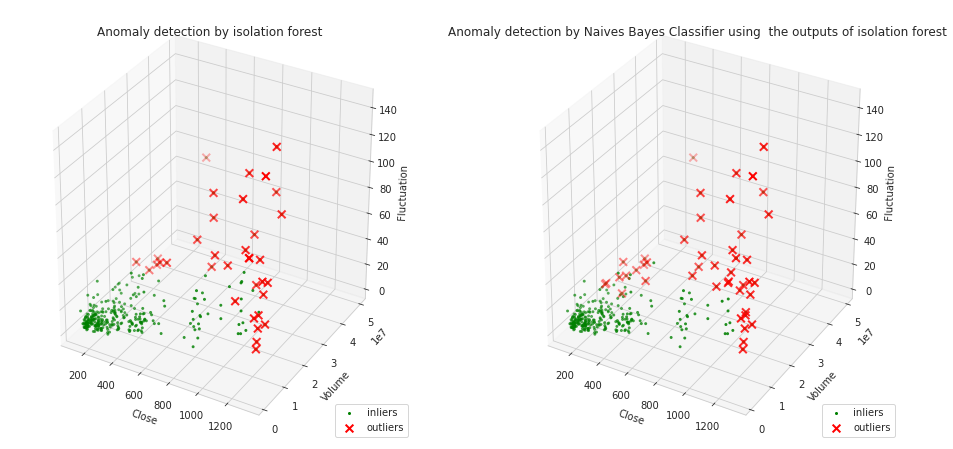

In [66]:
fig = plt.figure(figsize=(16,8))
ax = fig.add_subplot(1,2,1, projection='3d')
ax.set_zlabel("x_composite_3")
ax.scatter(df['Close'], df['Volume'], zs=df['Fluctuations'], s=4, lw=1, label="inliers",c="green")
ax.scatter(df1233[1],df1233[2],df1233[3], lw=2, s=60, marker="x", c="red", label="outliers")
ax.set_xlabel("Close")
ax.set_ylabel("Volume")
ax.set_zlabel("Fluctuation")
plt.title("Anomaly detection by isolation forest")
ax.legend(loc='lower right')


ax = fig.add_subplot(1, 2, 2, projection='3d')
ax.set_zlabel("x_composite_3")
ax.scatter(df['Close'], df['Volume'], zs=df['Fluctuations'], s=4, lw=1, label="inliers",c="green")
ax.scatter(dfnb1['Close'],dfnb1['Volume'], dfnb1['Fluctuations'],lw=2, s=60, marker="x", c="red", label="outliers")
ax.set_xlabel("Close")
ax.set_ylabel("Volume")
ax.set_zlabel("Fluctuation")
plt.title("Anomaly detection by Naives Bayes Classifier using  the outputs of isolation forest")
ax.legend(loc='lower right')
plt.show()

Similarly, Applying Naive-Bayes Classifier on the outputs of DBScan and finding out their class probabilities

In [67]:
df1234['Date'] = pd.to_datetime(df1234.Date, format='%Y-%m-%d')
x=df1234.Date.tolist()
len(x)

df['Anomaly']=""
for ind in df.index:                                        #Anomalyvalues are marked as 1 and otherwise they are market as 0
  if df['Date'][ind] in x:
    df['Anomaly'][ind]=1
  else:
    df['Anomaly'][ind]=0

target=df['Anomaly']
df.drop('Anomaly', axis=1, inplace =True)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [68]:
from sklearn.naive_bayes import GaussianNB

dataset=pd.DataFrame(df[['Close','Volume','Fluctuations']])
target=target.astype('int')

model=GaussianNB()
model.fit(dataset,target)
y=model.predict(dataset)
pred=model.predict_proba(dataset).round(2)
pred

array([[1.  , 0.  ],
       [1.  , 0.  ],
       [1.  , 0.  ],
       [1.  , 0.  ],
       [1.  , 0.  ],
       [1.  , 0.  ],
       [1.  , 0.  ],
       [1.  , 0.  ],
       [1.  , 0.  ],
       [1.  , 0.  ],
       [1.  , 0.  ],
       [1.  , 0.  ],
       [1.  , 0.  ],
       [1.  , 0.  ],
       [1.  , 0.  ],
       [1.  , 0.  ],
       [1.  , 0.  ],
       [1.  , 0.  ],
       [1.  , 0.  ],
       [1.  , 0.  ],
       [1.  , 0.  ],
       [1.  , 0.  ],
       [1.  , 0.  ],
       [1.  , 0.  ],
       [1.  , 0.  ],
       [1.  , 0.  ],
       [1.  , 0.  ],
       [1.  , 0.  ],
       [1.  , 0.  ],
       [1.  , 0.  ],
       [1.  , 0.  ],
       [1.  , 0.  ],
       [1.  , 0.  ],
       [1.  , 0.  ],
       [1.  , 0.  ],
       [1.  , 0.  ],
       [1.  , 0.  ],
       [1.  , 0.  ],
       [1.  , 0.  ],
       [1.  , 0.  ],
       [1.  , 0.  ],
       [1.  , 0.  ],
       [1.  , 0.  ],
       [1.  , 0.  ],
       [1.  , 0.  ],
       [1.  , 0.  ],
       [1.  , 0.  ],
       [1.  ,

In [69]:
df['anomalynb'] = y
dfnb2=pd.DataFrame()
dfnb2=pd.DataFrame(df[df['anomalynb']==1])
df.drop('anomalynb', axis=1, inplace =True)
dfnb2.shape[0]

15

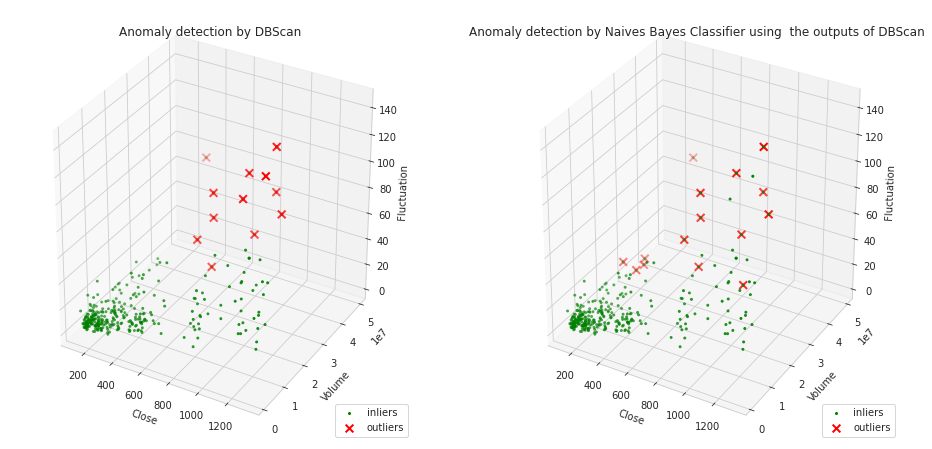

In [70]:
fig = plt.figure(figsize=(16,8))
ax = fig.add_subplot(1,2,1, projection='3d')
ax.set_zlabel("x_composite_3")
ax.scatter(df['Close'], df['Volume'], zs=df['Fluctuations'], s=4, lw=1, label="inliers",c="green")
ax.scatter(df1234['Close'],df1234['Volume'],df1234['Fluctuations'], lw=2, s=60, marker="x", c="red", label="outliers")
ax.set_xlabel("Close")
ax.set_ylabel("Volume")
ax.set_zlabel("Fluctuation")
plt.title("Anomaly detection by DBScan")
ax.legend(loc='lower right')


ax = fig.add_subplot(1, 2, 2, projection='3d')
ax.set_zlabel("x_composite_3")
ax.scatter(df['Close'], df['Volume'], zs=df['Fluctuations'], s=4, lw=1, label="inliers",c="green")
ax.scatter(dfnb2['Close'],dfnb2['Volume'], dfnb2['Fluctuations'],lw=2, s=60, marker="x", c="red", label="outliers")
ax.set_xlabel("Close")
ax.set_ylabel("Volume")
ax.set_zlabel("Fluctuation")
plt.title("Anomaly detection by Naives Bayes Classifier using  the outputs of DBScan")
ax.legend(loc='lower right')
plt.show()

Similarly, Applying Naive-Bayes Classifier on the outputs of HBOS and finding out their class probabilities

In [71]:
dfo2['Date'] = pd.to_datetime(dfo2.Date, format='%Y-%m-%d')
x=dfo2.Date.tolist()

df['Anomaly']=""
for ind in df.index:                                        #Anomalyvalues are marked as 1 and otherwise they are market as 0
  if df['Date'][ind] in x:
    df['Anomaly'][ind]=1
  else:
    df['Anomaly'][ind]=0

target=df['Anomaly']
df.drop('Anomaly', axis=1, inplace =True)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


In [72]:
from sklearn.naive_bayes import GaussianNB

dataset=pd.DataFrame(df[['Close','Volume','Fluctuations','Lag1', 'Lag2', 'Lag3','Lag4','Lag5']])
dataset=dataset.fillna(dataset.mode().iloc[0])
target=target.astype('int')

model=GaussianNB()
model.fit(dataset,target)
y=model.predict(dataset)
pred=model.predict_proba(dataset).round(2)
pred

array([[1.  , 0.  ],
       [1.  , 0.  ],
       [1.  , 0.  ],
       [1.  , 0.  ],
       [1.  , 0.  ],
       [1.  , 0.  ],
       [1.  , 0.  ],
       [1.  , 0.  ],
       [1.  , 0.  ],
       [1.  , 0.  ],
       [1.  , 0.  ],
       [1.  , 0.  ],
       [0.98, 0.02],
       [1.  , 0.  ],
       [1.  , 0.  ],
       [1.  , 0.  ],
       [1.  , 0.  ],
       [1.  , 0.  ],
       [1.  , 0.  ],
       [1.  , 0.  ],
       [1.  , 0.  ],
       [1.  , 0.  ],
       [1.  , 0.  ],
       [1.  , 0.  ],
       [1.  , 0.  ],
       [0.99, 0.01],
       [0.99, 0.01],
       [1.  , 0.  ],
       [1.  , 0.  ],
       [1.  , 0.  ],
       [1.  , 0.  ],
       [1.  , 0.  ],
       [1.  , 0.  ],
       [1.  , 0.  ],
       [1.  , 0.  ],
       [1.  , 0.  ],
       [1.  , 0.  ],
       [1.  , 0.  ],
       [1.  , 0.  ],
       [1.  , 0.  ],
       [1.  , 0.  ],
       [1.  , 0.  ],
       [1.  , 0.  ],
       [1.  , 0.  ],
       [1.  , 0.  ],
       [1.  , 0.  ],
       [1.  , 0.  ],
       [1.  ,

In [73]:
df['anomalynb'] = y
dfnb3=pd.DataFrame()
dfnb3=pd.DataFrame(df[df['anomalynb']==1])
df.drop('anomalynb', axis=1, inplace =True)
dfnb3.shape[0]

28

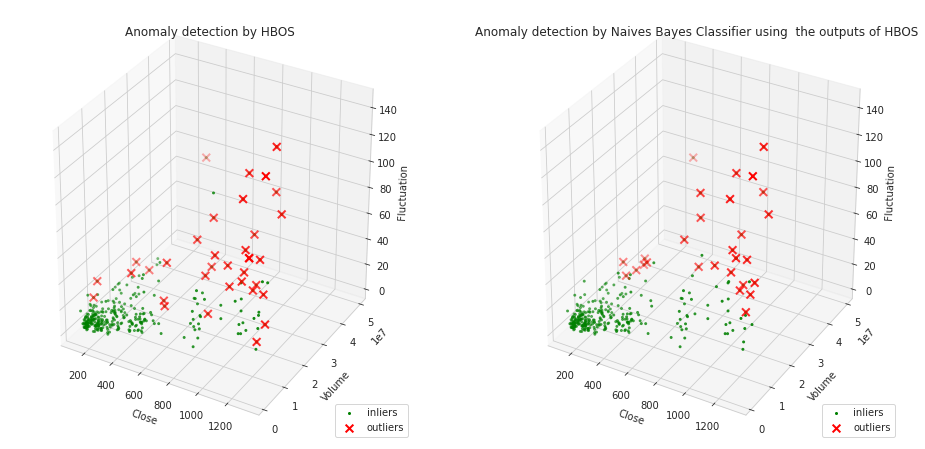

In [74]:
fig = plt.figure(figsize=(16,8))
ax = fig.add_subplot(1,2,1, projection='3d')
ax.set_zlabel("x_composite_3")
ax.scatter(df['Close'], df['Volume'], zs=df['Fluctuations'], s=4, lw=1, label="inliers",c="green")
ax.scatter(dfo2['Close'],dfo2['Volume'],dfo2['Fluctuations'], lw=2, s=60, marker="x", c="red", label="outliers")
ax.set_xlabel("Close")
ax.set_ylabel("Volume")
ax.set_zlabel("Fluctuation")
plt.title("Anomaly detection by HBOS")
ax.legend(loc='lower right')


ax = fig.add_subplot(1, 2, 2, projection='3d')
ax.set_zlabel("x_composite_3")
ax.scatter(df['Close'], df['Volume'], zs=df['Fluctuations'], s=4, lw=1, label="inliers",c="green")
ax.scatter(dfnb3['Close'],dfnb3['Volume'], dfnb3['Fluctuations'],lw=2, s=60, marker="x", c="red", label="outliers")
ax.set_xlabel("Close")
ax.set_ylabel("Volume")
ax.set_zlabel("Fluctuation")
plt.title("Anomaly detection by Naives Bayes Classifier using  the outputs of HBOS")
ax.legend(loc='lower right')
plt.show()

Finally Applying Naive-Bayes Classifier on the outputs of Local Outlier forest and finding out their class probabilities

In [75]:
df1236['Date'] = pd.to_datetime(df1236.Date, format='%Y-%m-%d')
x=df1236.Date.tolist()

df['Anomaly']=""
for ind in df.index:                                        #Anomalyvalues are marked as 1 and otherwise they are market as 0
  if df['Date'][ind] in x:
    df['Anomaly'][ind]=1
  else:
    df['Anomaly'][ind]=0

target=df['Anomaly']
df.drop('Anomaly', axis=1, inplace =True)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


In [76]:
from sklearn.naive_bayes import GaussianNB

dataset=pd.DataFrame(df[['Close','Volume','Fluctuations']])
dataset=dataset.fillna(dataset.mode().iloc[0])
target=target.astype('int')

model=GaussianNB()
model.fit(dataset,target)
y=model.predict(dataset)
pred=model.predict_proba(dataset).round(2)
pred

array([[0.92, 0.08],
       [0.93, 0.07],
       [0.93, 0.07],
       [0.93, 0.07],
       [0.93, 0.07],
       [0.94, 0.06],
       [0.93, 0.07],
       [0.93, 0.07],
       [0.93, 0.07],
       [0.92, 0.08],
       [0.92, 0.08],
       [0.93, 0.07],
       [0.9 , 0.1 ],
       [0.93, 0.07],
       [0.93, 0.07],
       [0.93, 0.07],
       [0.93, 0.07],
       [0.93, 0.07],
       [0.93, 0.07],
       [0.92, 0.08],
       [0.93, 0.07],
       [0.92, 0.08],
       [0.93, 0.07],
       [0.93, 0.07],
       [0.92, 0.08],
       [0.92, 0.08],
       [0.92, 0.08],
       [0.93, 0.07],
       [0.93, 0.07],
       [0.93, 0.07],
       [0.93, 0.07],
       [0.93, 0.07],
       [0.93, 0.07],
       [0.92, 0.08],
       [0.93, 0.07],
       [0.92, 0.08],
       [0.93, 0.07],
       [0.93, 0.07],
       [0.93, 0.07],
       [0.93, 0.07],
       [0.93, 0.07],
       [0.93, 0.07],
       [0.93, 0.07],
       [0.93, 0.07],
       [0.93, 0.07],
       [0.93, 0.07],
       [0.93, 0.07],
       [0.93,

In [77]:
df['anomalynb'] = y
dfnb4=pd.DataFrame()
dfnb4=pd.DataFrame(df[df['anomalynb']==1])
df.drop('anomalynb', axis=1, inplace =True)
dfnb4.shape[0]

13

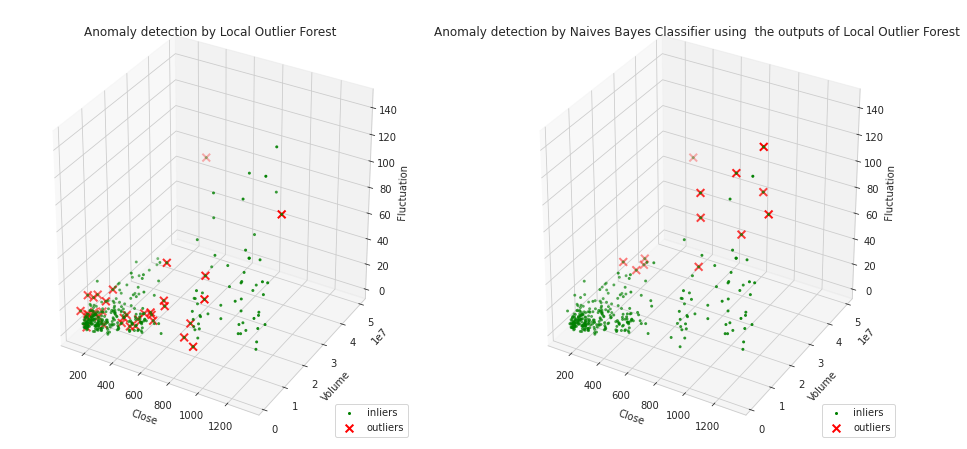

In [78]:
fig = plt.figure(figsize=(16,8))
ax = fig.add_subplot(1,2,1, projection='3d')
ax.set_zlabel("x_composite_3")
ax.scatter(df['Close'], df['Volume'], zs=df['Fluctuations'], s=4, lw=1, label="inliers",c="green")
ax.scatter(df1236['Close'],df1236['Volume'],df1236['Fluctuations'], lw=2, s=60, marker="x", c="red", label="outliers")
ax.set_xlabel("Close")
ax.set_ylabel("Volume")
ax.set_zlabel("Fluctuation")
plt.title("Anomaly detection by Local Outlier Forest")
ax.legend(loc='lower right')


ax = fig.add_subplot(1, 2, 2, projection='3d')
ax.set_zlabel("x_composite_3")
ax.scatter(df['Close'], df['Volume'], zs=df['Fluctuations'], s=4, lw=1, label="inliers",c="green")
ax.scatter(dfnb4['Close'],dfnb4['Volume'], dfnb4['Fluctuations'],lw=2, s=60, marker="x", c="red", label="outliers")
ax.set_xlabel("Close")
ax.set_ylabel("Volume")
ax.set_zlabel("Fluctuation")
plt.title("Anomaly detection by Naives Bayes Classifier using  the outputs of Local Outlier Forest")
ax.legend(loc='lower right')
plt.show()

Hence it can be inferred that NB classifier performed significantly well than the DBScan,it's performance wasn't as good as HBOS and LOF because of it's inability to detect local outlers.Hence it using NB Classifier is not helping us fine-tune the model.